In [1]:
from cgi import test
from lib2to3.pgen2.pgen import DFAState
from lib2to3.refactor import get_all_fix_names
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import env
from pydataset import data
import scipy
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

### Acquire

In [2]:
#acquiring data
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def get_logs_data():
    #in this data set I will be importing (Properties_2017, Predictions_2017, Propertylandusetype) to allow me to look into zillows single family home data. (which is what we are interested in."""
    filename = "logs.csv"

    if os.path.isfile(filename):
        return pd.read_csv(filename)
    else:
        # read the SQL query into a dataframe, left join to grab data regardless of wather it shares same info, anf join regularly for center join.
        
        df = pd.read_sql("""SELECT *
          FROM api_access; """, get_connection('logs')) 
         # Write that dataframe to disk for later. Called "caching" the data for later.
        df.to_csv(filename, index = False)
        #changing it csv because its a csv

        # Return the dataframe to the calling code
        return 

In [3]:
df = get_logs_data()
df

,entry
0,"97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ""GET /api/v1/sales?page=81 HTTP/1.1"" 200..."
1,"97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ""GET /api/v1/items HTTP/1.1"" 200 3561 ""-..."
2,"97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ""GET /api/v1/sales?page=82 HTTP/1.1"" 200..."
3,"97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ""GET /api/v1/sales?page=83 HTTP/1.1"" 200..."
4,"97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ""GET /api/v1/sales?page=84 HTTP/1.1"" 200..."
...,...
13969,"97.105.19.58 - - [17/Apr/2019:12:55:12 +0000] ""GET /api/v1/sales?page=62 HTTP/1.1"" 200..."
13970,"97.105.19.58 - - [17/Apr/2019:12:55:12 +0000] ""GET /api/v1/sales?page=65 HTTP/1.1"" 200..."
13971,"97.105.19.58 - - [17/Apr/2019:12:55:13 +0000] ""GET /api/v1/sales?page=73 HTTP/1.1"" 200..."
13972,"97.105.19.58 - - [17/Apr/2019:12:55:13 +0000] ""GET /api/v1/sales?page=69 HTTP/1.1"" 200..."


# Wrangle

In [4]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


### Creating some sythetic records and append them to our existing data frame.

In [5]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)


In [6]:
df

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
13973,97.105.19.58,17/Apr/2019 12:55:14,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0
0,95.31.18.119,21/Apr/2019 10:02:41,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0
1,95.31.16.121,17/Apr/2019 19:36:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0
2,97.105.15.120,18/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0


In [7]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')
df

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246
...,...,...,...,...,...,...,...,...
2019-04-17 12:55:14,97.105.19.58,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0,0.486532
2019-04-21 10:02:41,95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958


In [8]:
df.ip.value_counts().head()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
Name: ip, dtype: int64

In [9]:
df.ip.value_counts(normalize=True).head()


97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
Name: ip, dtype: float64

### Define a function that combines both these pieces of information:

In [18]:
# (->) Forces it to be a dataframe. (s:) it is going to be a series

def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )


In [11]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()


,count,proba
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502


### How many unique ip addresses there are?

<AxesSubplot:>

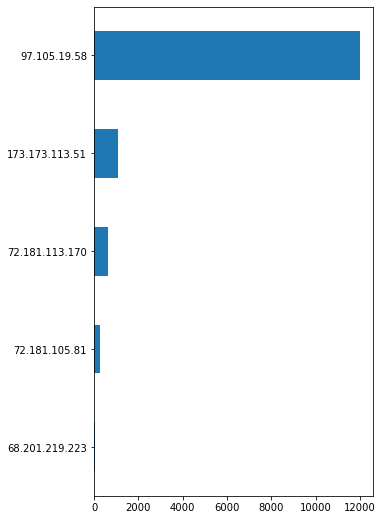

In [12]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))


### Conditional Probabilities: Probabilities using 2 discrete variables

In [13]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()


,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [14]:
status_given_ip[status_given_ip.status_code != '200']


,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


### This is interesting -- we have detected two ip addresses who only received 301 response codes. Let's investigate one further:

In [15]:
df[df.ip == '97.105.15.120']


,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441


In [16]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]


,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


In [25]:
df.request_method.unique()

array(['GET'], dtype=object)

In [26]:
df

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246
...,...,...,...,...,...,...,...,...
2019-04-17 12:55:14,97.105.19.58,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0,0.486532
2019-04-21 10:02:41,95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0,0.000958


In [31]:
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
95.31.16.121          1
95.31.18.119          1
45.23.250.16          1
52.91.30.150          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
3.92.201.136          1
35.174.209.2          1
54.145.52.184         1
34.229.70.250         1
97.105.15.120         1
Name: ip, dtype: int64

***

In [32]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

http_version         0
ip                   0
request_method       0
request_path         0
size              1660
size_mb           1660
status_code          0
user_agent           0
dtype: int64

In [33]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
((df < (Q1 - 3 * IQR)) | (df > (Q3 + 3 * IQR))).sum()

http_version         0
ip                   0
request_method       0
request_path         0
size              1660
size_mb           1660
status_code          0
user_agent           0
dtype: int64

***

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42 to 2019-04-19 19:42:41
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ip              13978 non-null  object 
 1   request_method  13978 non-null  object 
 2   request_path    13978 non-null  object 
 3   http_version    13978 non-null  object 
 4   status_code     13978 non-null  object 
 5   size            13978 non-null  int64  
 6   user_agent      13978 non-null  object 
 7   size_mb         13978 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 982.8+ KB


In [35]:
df.request_method.value_counts()

GET    13978
Name: request_method, dtype: int64

In [38]:
df.request_method.value_counts(normalize=True).head()

GET    1.0
Name: request_method, dtype: float64

In [36]:
df.request_path.value_counts()

/api/v1/sales?page=2               709
/api/v1/items                      464
/api/v1/items?page=2               291
/api/v1/items?page=3               219
/api/v1/stores                     162
                                  ... 
/api/v1                              1
/api/v1//api/v1/items/next_page      1
/api/v1//api/v1/items                1
/api/v1/items?page=0                 1
/api/V1/HiZach!                      1
Name: request_path, Length: 220, dtype: int64

In [37]:
df.request_path.value_counts(normalize=True).head()


/api/v1/sales?page=2    0.050723
/api/v1/items           0.033195
/api/v1/items?page=2    0.020818
/api/v1/items?page=3    0.015667
/api/v1/stores          0.011590
Name: request_path, dtype: float64

In [39]:
request_path_df = value_counts_and_frequencies(df.request_path)
request_path_df.head()


,count,proba
/api/v1/sales?page=2,709,0.050723
/api/v1/items,464,0.033195
/api/v1/items?page=2,291,0.020818
/api/v1/items?page=3,219,0.015667
/api/v1/stores,162,0.011590


<AxesSubplot:>

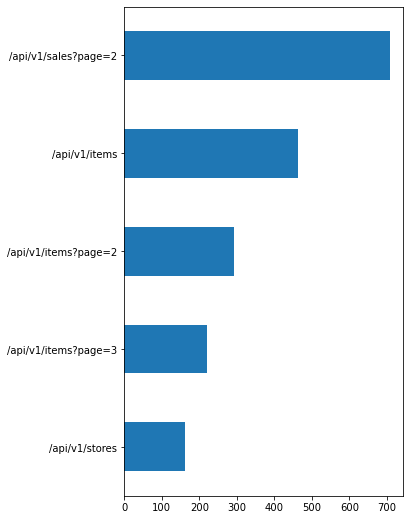

In [40]:
request_path_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

In [41]:
status_given_request_path = (
    df.groupby('request_path')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_request_path')
    .reset_index()
)
status_given_request_path.head()


,request_path,status_code,proba_status_given_request_path
0,/,200,1.0
1,/api/V1/HiZach!,200,1.0
2,/api/v1,200,1.0
3,/api/v1/,200,1.0
4,/api/v1//api/v1/items,200,1.0


### http_version

In [43]:
df.http_version.value_counts()

HTTP/1.1    13978
Name: http_version, dtype: int64

### status_code

In [45]:
df.status_code.value_counts()

200    13960
499       16
301        2
Name: status_code, dtype: int64

In [46]:
df.status_code.value_counts(normalize=True).head()

200    0.998712
499    0.001145
301    0.000143
Name: status_code, dtype: float64

In [47]:
status_code_df = value_counts_and_frequencies(df.status_code)
status_code_df.head()


,count,proba
200,13960,0.998712
499,16,0.001145
301,2,0.000143


<AxesSubplot:>

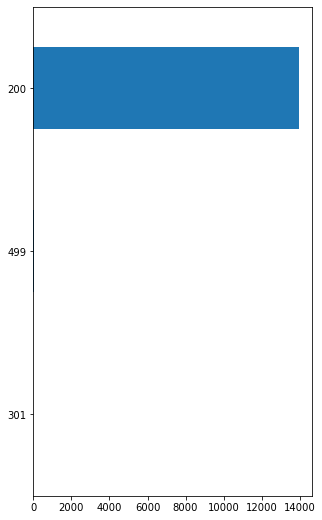

In [48]:
status_code_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))


In [55]:
status_given_ip[status_given_ip.status_code != '499']


,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [54]:
status_given_ip[status_given_ip.status_code != '301']

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [ ]:
helo s